## Semantic Segmentation




### Reference
* [PyTorch Tutorial Semantic-Segmentation](https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/)
* [Blog: An overview of Semantic-segmentation](https://www.jeremyjordan.me/semantic-segmentation/)
* [CS231N Lecture11: Detection and Segmentation](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf)
* [Fully Convolutional Networks paper](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf)


<img src="http://drive.google.com/uc?export=view&id=1dTAPbCKJtwTW1DY6GxCcytCIDfzK_9Nc" width="50%" height="60%">

<img src="http://drive.google.com/uc?export=view&id=1exFBUkwh3SqO7w75WtByWGmDkScJs1Ts" width="80%" height="85%">

### GOALS
  Semantic Segmentation is an image analysis task in which we classify each pixel in the image into a class.

1. We will first download a pre-trained weight of segmentation.
2. Then, we will test the network with downloaded image files or your local images


### Import

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import models
from torchvision import transforms as T

### Download images

In [10]:


!wget https://www.birds.cornell.edu/home/wp-content/uploads/2023/09/334289821-Baltimore_Oriole-Matthew_Plante.jpg -O bird.png
!wget https://t4.ftcdn.net/jpg/01/11/43/91/240_F_111439156_trDjm4XKyJC7v3utukT6JAKdL2vX0vzj.jpg -O horse.png
!wget https://user-images.githubusercontent.com/1592542/39029840-8f5989ee-444d-11e8-9071-52cb526824cf.jpg -O bicycle.jpg
!wget https://youthtoday.org/wp-content/uploads/sites/13/2019/05/OPED-DeanDrobot-Shutterstock_1207772488.jpg -O person.png

--2024-10-04 08:33:56--  https://www.birds.cornell.edu/home/wp-content/uploads/2023/09/334289821-Baltimore_Oriole-Matthew_Plante.jpg
Resolving www.birds.cornell.edu (www.birds.cornell.edu)... 141.193.213.10, 141.193.213.11
Connecting to www.birds.cornell.edu (www.birds.cornell.edu)|141.193.213.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105807 (103K) [image/jpeg]
Saving to: ‘bird.png’

bird.png            100%[===================>] 103.33K  --.-KB/s    in 0.02s   

2024-10-04 08:33:56 (6.56 MB/s) - ‘bird.png’ saved [105807/105807]

--2024-10-04 08:33:56--  https://t4.ftcdn.net/jpg/01/11/43/91/240_F_111439156_trDjm4XKyJC7v3utukT6JAKdL2vX0vzj.jpg
Resolving t4.ftcdn.net (t4.ftcdn.net)... 151.101.1.91, 151.101.65.91, 151.101.129.91, ...
Connecting to t4.ftcdn.net (t4.ftcdn.net)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35553 (35K) [image/jpeg]
Saving to: ‘horse.png’

horse.png           100%[===================>]

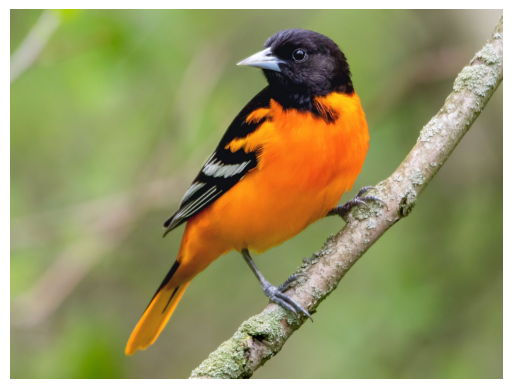

In [9]:
bird = Image.open('bird.png')
horse = Image.open('horse.png')
bicycle = Image.open('bicycle.jpg')
person = Image.open('person.png')

plt.imshow(bird); plt.axis('off'); plt.show()

### Pre-trained model

In [10]:
# FCN and DeepLabV3 (backbone: ResNet50, ResNet101)

fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()
deeplab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:12<00:00, 18.1MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are dep

In [19]:
def preprocess_image(image):

  trf = T.Compose([T.Resize(640),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])

  return trf(image).unsqueeze(0)

In [20]:
# Define the helper function
def decode_segmap(image, nc=21):

  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [22]:
def segment(net, image):

  # Preprocessing
  inp = preprocess_image(image)

  # Pretrained model
  out = net(inp)['out']

  # max index for each pixel, which represents the class
  om = torch.argmax(out.squeeze(), dim=0).cpu().numpy()

  # Convert 2D image to an RGB image color
  rgb = decode_segmap(om)

  plt.imshow(rgb)
  plt.axis('off')
  plt.show()

### Inference

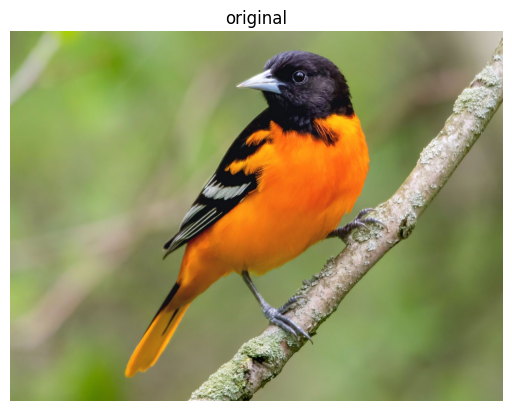

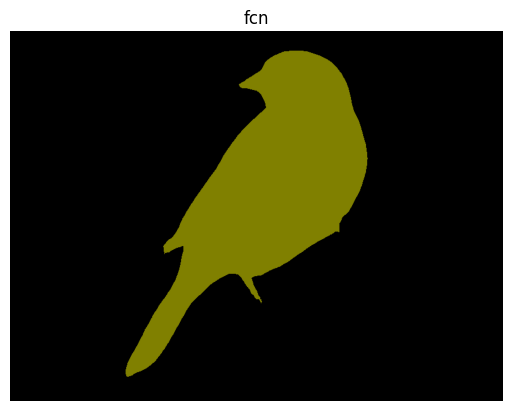

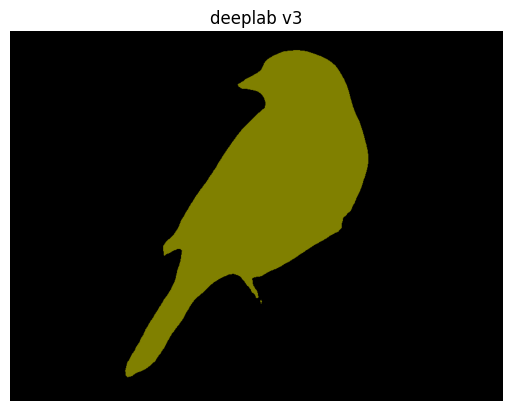

In [23]:
plt.title('original'); plt.imshow(bird); plt.axis('off'); plt.show()

plt.title('fcn')
segment(fcn, bird)

plt.title('deeplab v3')
segment(deeplab, bird)

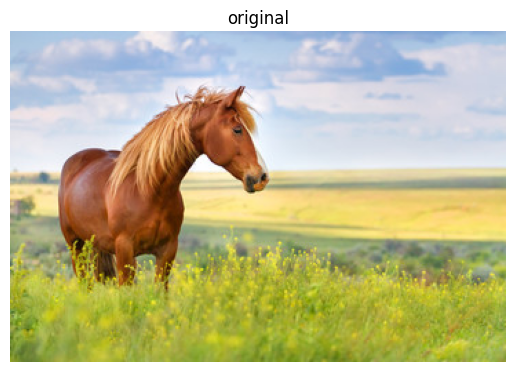

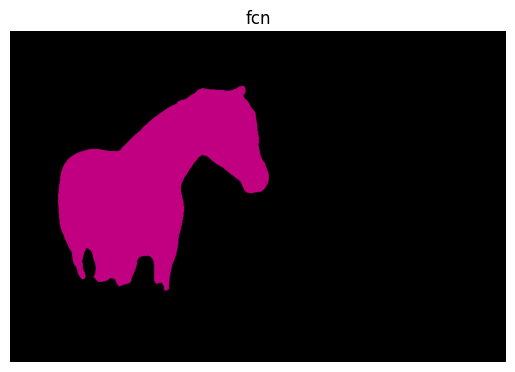

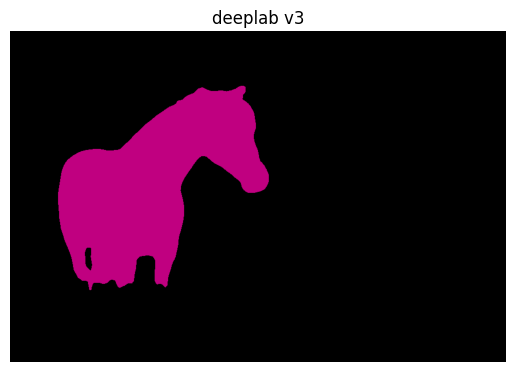

In [24]:
plt.title('original'); plt.imshow(horse); plt.axis('off'); plt.show()

plt.title('fcn')
segment(fcn, horse)

plt.title('deeplab v3')
segment(deeplab, horse)

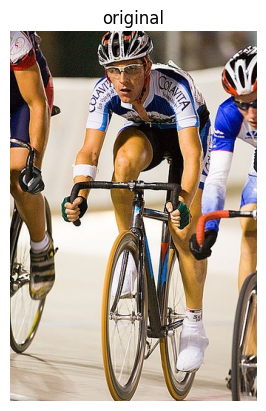

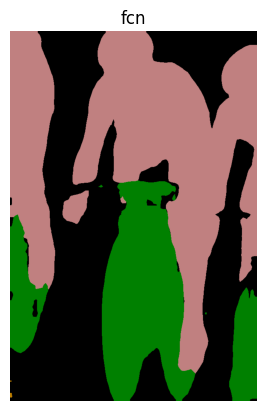

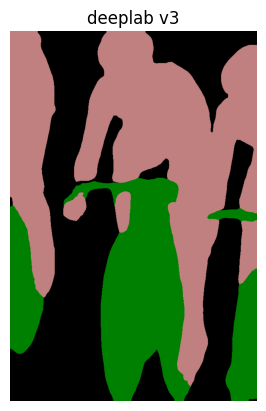

In [25]:
plt.title('original'); plt.imshow(bicycle); plt.axis('off'); plt.show()


plt.title('fcn')
segment(fcn, bicycle)

plt.title('deeplab v3')
segment(deeplab, bicycle)

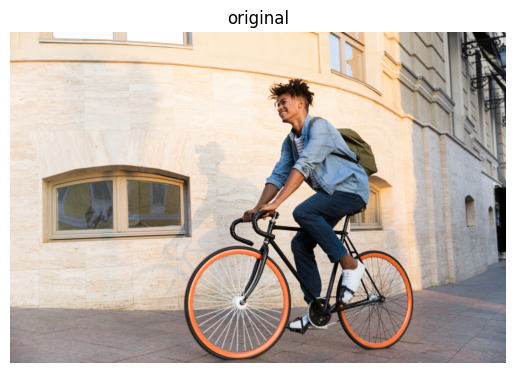

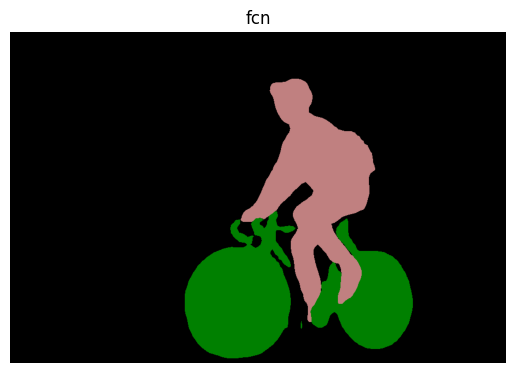

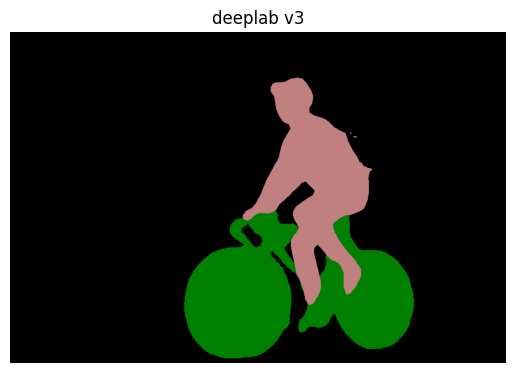

In [26]:
plt.title('original'); plt.imshow(person); plt.axis('off'); plt.show()

plt.title('fcn')
segment(fcn, person)

plt.title('deeplab v3')
segment(deeplab, person)

### Remove specific object

In [27]:
def reduce_object(image, target, nc=21):

  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(nc):
    if l == target:
      continue
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [31]:
def segment_reduce_object(net, image, target):

  # Preprocessing
  inp = preprocess_image(image)

  # Pretrained model
  out = net(inp)['out']

  # max index for each pixel, which represents the class
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()

  labels = {'background' : 0, 'aeroplane' : 1,'bicycle' : 2, 'bird' : 3,
            'boat' : 4, 'bottle' : 5, 'bus' : 6, 'car' : 7,
            'cat' : 8, 'chair' : 9, 'cow' : 10, 'dining table' : 11,
            'dog' : 12, 'horse' : 13, 'motorbike' : 14, 'person' : 15,
            'potted plant' : 16, 'sheep' : 17, 'sofa' : 18, 'train' : 19, 'monitor' : 20}

  rgb = reduce_object(om, labels[target])

  plt.imshow(rgb)
  plt.axis('off')
  plt.show()

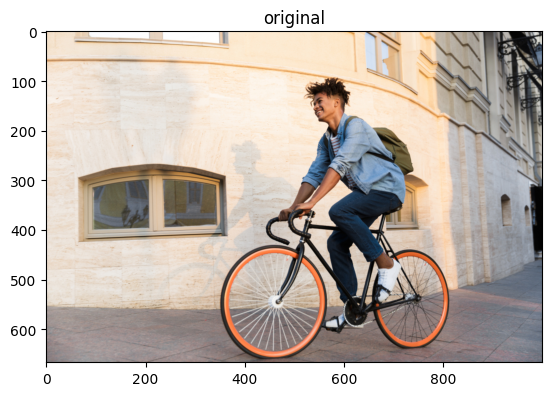

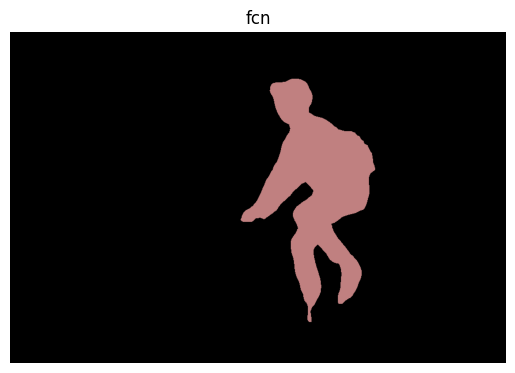

In [32]:
plt.title('original'); plt.imshow(person); plt.show()

plt.title('fcn')
segment_reduce_object(fcn, person, 'bicycle')

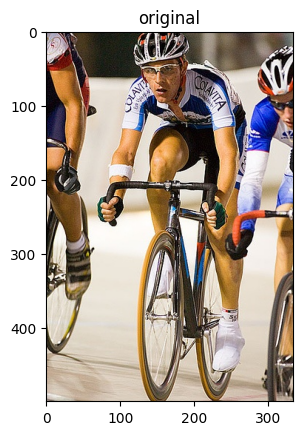

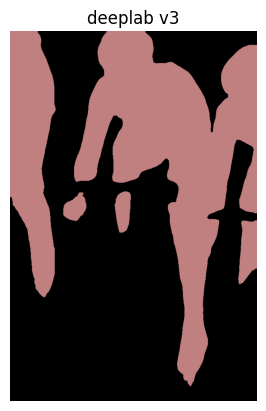

In [33]:
plt.title('original'); plt.imshow(bicycle); plt.show()

plt.title('deeplab v3')
segment_reduce_object(deeplab, bicycle, 'bicycle')

### FCN vs DeepLab v3